In [1]:
import numpy as np
import quaternion
from numpy import linalg as LA
from math import *
from pyluos import Robot
import time

x0 = [1, 0, 0]
y0 = [0, 1, 0]
z0 = [0, 0, 1]

x0_quat = quaternion.quaternion(0,1,0,0)
y0_quat = quaternion.quaternion(0,0,1,0)
z0_quat = quaternion.quaternion(0,0,0,1)

Pc = [0,0,89.40]   #Coordinates of the plateform's center
C = [0,0,64.227]   #Coordinates of the center of the proximal circle
R = 39.162   #Radius of the distal circle
Rp = R*cos(40.0*pi/180)   #Radius of the proximal center

/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [2]:
def get_new_frame(Q):
 #1st rotation quaternion
    if type(Q)==type((0,0,0)):
        q1 = quaternion.quaternion(Q[0],Q[1],Q[2],Q[3])
    
    q1_inv = q1.inverse()


    new_z = q1*z0_quat*q1_inv #Final Z
    new_x = q1*x0_quat*q1_inv#Final X
    new_y = q1*y0_quat*q1_inv#Final Y

    X = [new_x.x, new_x.y, new_x.z]
    Y = [new_y.x, new_y.y, new_y.z]
    Z = [new_z.x, new_z.y, new_z.z]
    
    return X,Y,Z

In [3]:
def Q_angles(Q,last_angles):
    quat = quaternion.quaternion(Q[0],Q[1],Q[2],Q[3])
    ### Find q31 and q11 ###
    X,Y,Z = get_new_frame(quat)
    q31_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q31_[0]<=180:
        q31 = q31_[0]
    else :
        q31= q31_[1]
    num1=Z[1]*cos(q31)+X[1]*sin(q31)
    den1=Z[0]*cos(q31)+X[0]*sin(q31)
    q11 = atan2(num1,den1)
    
    ### Find q32 and q12 ###
    w_offset = cos(2*pi/6.0)
    x_offset = sin(2*pi/6.0)*z0_quat.x
    y_offset = sin(2*pi/6.0)*z0_quat.y
    z_offset = sin(2*pi/6.0)*z0_quat.z

    q_offset = quaternion.quaternion(w_offset,x_offset,y_offset,z_offset) #1st rotation quaternion
    
    X,Y,Z = get_new_frame(quat*q_offset)
    q32_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q32_[0]<=180:
        q32 = q32_[0]
    else :
        q32= q32_[1]
    num2=(Z[1]*cos(q32)+X[1]*sin(q32))
    den2=(Z[0]*cos(q32)+X[0]*sin(q32))
    q12 = atan2(num2,den2)
    
    ### Find q33 and q13 ###
    w_offset = cos(-2*pi/6.0)
    x_offset = sin(-2*pi/6.0)*z0_quat.x
    y_offset = sin(-2*pi/6.0)*z0_quat.y
    z_offset = sin(-2*pi/6.0)*z0_quat.z

    q_offset = quaternion.quaternion(w_offset,x_offset,y_offset,z_offset) #1st rotation quaternion
    
    X,Y,Z = get_new_frame(quat*q_offset)
    q33_ = [2*atan2((R*X[2] - sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2])), 2*atan2((R*X[2] + sqrt(R**2*X[2]**2 + R**2*Z[2]**2 - C[2]**2 + 2*C[2]*Pc[2] - Pc[2]**2)),(R*Z[2] + C[2] - Pc[2]))]

    if 0<=q33_[0]<=180:
        q33 = q33_[0]
    else :
        q33= q33_[1]
    num3=(Z[1]*cos(q33)+X[1]*sin(q33))
    den3=(Z[0]*cos(q33)+X[0]*sin(q33))
    q13 = atan2(num3,den3)
    
    if (abs(q11-last_angles[0])>=2.96):
        if last_angles[0]>0:
            q11=q11+2*pi
        elif last_angles[0]<0:
            q11=q11-2*pi
    if (abs(q12-last_angles[1])>=2.96):
        if last_angles[1]>0:
            q12=q12+2*pi
        elif last_angles[1]<0:
            q12=q12-2*pi
    if (abs(q13-last_angles[2])>=2.96):
        if last_angles[2]>0:
            q13=q13+2*pi
        elif last_angles[2]<0:
            q13=q13-2*pi

    
    return [q11*180/pi,(q12*180/pi)-120,(q13*180/pi)+120]

In [4]:
r = Robot('/dev/cu.usbserial-DN05NM0L')
r.gate.delay=10
r.disk_bottom.rot_position=False
r.disk_middle.rot_position=False
r.disk_top.rot_position=False

###########Setup############

r.disk_bottom.encoder_res = 5
r.disk_middle.encoder_res = 5
r.disk_top.encoder_res = 5


r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()


r.disk_bottom.reduction = 232
r.disk_middle.reduction = 232
r.disk_top.reduction = 232


r.disk_bottom.wheel_size = 60.0
r.disk_middle.wheel_size = 60.0
r.disk_top.wheel_size = 60


r.disk_bottom.positionPid = [9,0.02,100]
r.disk_middle.positionPid = [9,0.02,100]
r.disk_top.positionPid = [9,0.02,100]


r.disk_bottom.rot_position_mode(True)
r.disk_middle.rot_position_mode(True)
r.disk_top.rot_position_mode(True)

Connected to "/dev/cu.usbserial-DN05NM0L".
Sending detection signal.
Waiting for route table...
Robot setup.


In [5]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

In [6]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

In [7]:
##### Remise à zéro #####
r.disk_bottom.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_top.target_rot_position = 0

In [ ]:
last_angles = [0,2*pi/3,-2*pi/3]

while(True):
    imu_quat = r.Imu_mod.quaternion
    Q=Q_angles(imu_quat,last_angles)
    last_angles=[Q[0]*pi/180,Q[1]*pi/180,Q[2]*pi/180]
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]
    r.disk_bottom.target_rot_position = Q[2]

    time.sleep(0.01)
 


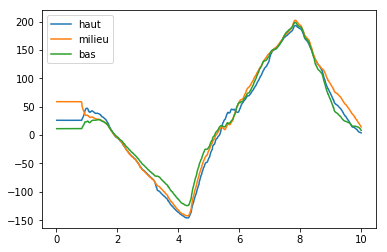

In [19]:
from matplotlib import pyplot as plt
plt.plot(T,q_top, label='haut')
plt.plot(T,q_middle, label='milieu')
plt.plot(T,q_bottom, label='bas')
plt.legend()

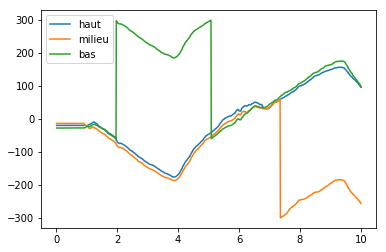

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/augustin/Downloads/pyluos/pyluos/io/serial_io.py", line 83, in _poll
    to_read = self._serial.in_waiting
  File "/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/serial/serialposix.py", line 467, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 6] Device not configured



In [9]:
from matplotlib import pyplot as plt
plt.plot(T,q_top, label='haut')
plt.plot(T,q_middle, label='milieu')
plt.plot(T,q_bottom, label='bas')
plt.legend()